In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from time import time
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

err2 = lambda x, y: np.sqrt(mean_squared_error(x,y))

In [3]:
class Experiment():

    def __init__(self, t_f, x_f, t_l = None, x_l = None, algorithm = linear_model.LinearRegression()):

        self.t_f = t_f # Position of time (or index axis) of the Model
        self.x_f = x_f # Position of space (or column axis) of the Model
        self.t_l = t_l # Position of time (or index axis) of the Labels (E.g. solution for SPDEs)
        self.x_l = x_l # Position of space (or column axis) of the Labels (E.g. solution for SPDEs)

        self.algorithm = algorithm # algorithm used for learning

        self.F = None # Features df
        self.L = None # Labels df
        self.learning_model = None
        self.train = None # list of features that are taken for training
        self.test = None # list of features that are taken for testing
        self.prediction = None # predicted values using the testing features
        self.error = None # error for the current split
        self.tangent = None # tangent for the current split
        self.error_std = None # standard deviation of the error
        self.r2 = None # R^2 of the error
        self.data_metrics = ['Error', 'Error Std', 'Slope', 'R^2']
        self.data_slice = {col:0 for col in self.data_metrics}
        self.error_message = ''

    # Create a dataframe of features out of a Model.
    def Create_Features(self, Models):
        if Models is None:
            print('Models are not given')
            return
        print('Creating features dataset.')
        if type(Models) is list: # List of Models is given
            num = len(Models) # number of realizations
            trees = list(Models[0].keys())  # all the trees
            X = Models[0][trees[0]].columns  # all the space points
        else: # df of Models is given
            num = Models.columns.levshape[0]
            trees = [m[0] for m in Models["M1"].columns[::Models["M1"].columns.levshape[1]]]
            X = Models["M1"][trees[0]].columns

        self.F = pd.DataFrame(index=np.arange(num), columns=trees)  # Features data of model
        
        for i in tqdm(range(num)): # i-th datapoint of the model
            if type(Models) is list:
                self.F.iloc[i] = [Models[i][A][X[self.x_f]].iloc[self.t_f] for A in trees]
            else:
                self.F.iloc[i] = [Models['M' + str(i + 1)][A][X[self.x_f]].iloc[self.t_f] for A in trees]

    # Create a df of labels out of results
    def Create_Labels(self, Results):
        if Results is None:
            print('Results are not given')
            return
        
        if self.t_l == None and self.x_l == None: # If t_l = x_l = None then consider Results as a label dataframe
            self.L = Results
        else:
            print('Creating labels dataset.')
            num = Results.columns.levshape[0]
            t, x = Results['S1'].index[self.t_l], Results['S1'].columns[self.x_l]
            self.L = pd.DataFrame(index=np.arange(num), columns=['(' + str(t) + ',' + str(x) + ')'])
            cols = Results['S1'].columns
            for i in tqdm(range(num)):  # i-th datapoint of the results
                if self.t_l == None:
                    self.L.iloc[i] = Results['S' + str(i + 1)][cols[self.x_l]].iloc[-1]
                elif self.x_l == None:
                    self.L.iloc[i] = Results['S' + str(i + 1)][cols[self.x_l]].iloc[self.t_l]
                else:
                    self.L.iloc[i] = Results['S' + str(i + 1)][cols[self.x_l]].iloc[self.t_l]

    # Perform learning of the solution from the model at a space-time point (m, n_S).
    # By default learning algorithm is linear regression. "metric" is the metric of computing the error
    # By default "metric" is equal to the mean absolute error = 1/p \sum_1^p |real_i - prediction_i| where p is the number
    # of predicted data point (p = test_size*num_of_datapoints).
    def one_experiment(self, Models = None, Results = None, split = True,  test_size=0.3, columns = None):

        if self.F is None:
            self.Create_Features(Models)
        if self.L is None:
            self.Create_Labels(Results)
        if columns is None:
            columns = self.F.columns

        # split data into test and train
        if split:
            X_train, X_test, y_train, y_test = train_test_split(self.F[columns], self.L, test_size=test_size)
            self.test, self.train = list(X_test.index), list(X_train.index)
        else:
            X_train, X_test, y_train, y_test = self.F.iloc[self.train], self.F.iloc[self.test], self.L.iloc[self.train], self.L.iloc[self.test]

        self.learning_model = self.algorithm.fit(X_train, y_train)  # fit the model with train data
        self.prediction = self.learning_model.predict(X_test)  # compute the prediction
        self.r2 = r2_score(y_test, self.prediction)

    def show_regression_experiment(self, metric = None, scale = True):

        if self.learning_model is None:
            print('There is not model created')
            return

        try: real = self.L.iloc[self.test].values # actual values
        except: real = self.L[self.test]
        # compute the regression line between predicted and real data. I.e. prediction = a*real + b
        # Ideal scenario is when a = 1, b = 0
        fitting = linear_model.LinearRegression().fit(real.reshape(-1, 1), self.prediction.reshape(real.shape))
        try: b, a = fitting.intercept_, fitting.coef_[0][0]
        except: b, a = fitting.intercept_, fitting.coef_[0]
        y_min, y_max = min(self.prediction), max(self.prediction)
        x_min, x_max = min(real), max(real)
        size_y, size_x = np.abs(y_max-y_min), np.abs(x_max-x_min)
        self.tangent = a
        fig = plt.figure(figsize=(14, 9))
        plt.scatter(real, self.prediction)
        plt.plot(real, b + real * a, 'r', label='Regression line between predicted and u(t,x)')
        plt.plot(real, real, 'g', label='y=x line')
        #plt.title("Comparison of predicted vs actual values of u(t,x).", fontsize=20)
        plt.xlabel("Values of u(t,x)", fontsize=20)
        plt.ylabel("Predicted Values", fontsize=20)
        plt.legend(loc=2, prop={'size': 15})
        plt.show();
        
        if metric:
            e, s, t, r = self.regression_error(metric=metric, scale=scale)
            print("Error: {}. Error std: {}. Tangent: {}. R^2: {}.".format(e, s, t, r))

        return

    def regression_error(self, metric = err2, scale = True):

        if self.learning_model is None:
            print('There is not model created.')
            return

        try: real = self.L.iloc[self.test].values
        except: real = self.L[self.test]
        fitting = linear_model.LinearRegression().fit(real.reshape(-1, 1), self.prediction)
        try: self.tangent = fitting.coef_[0][0]
        except: self.tangent = fitting.coef_[0]
        self.error = metric(self.prediction, real)
        scale_factor = metric(np.zeros(len(real)), real) if scale else 1
        errors_vector = (np.abs(self.prediction - real)/scale_factor).flatten()
        self.error_std = np.sqrt(mean_squared_error(np.array([self.error]*len(real)), errors_vector))
        

        return self.error/scale_factor, self.error_std, self.tangent, self.r2

    # Perform several experiments to deduce the average error and a slope for this model
    def many_regression_experiments(self, num, Models = None, Results = None, test_size=0.3, metric = err2, scale = True, columns = None, mini = False, maxi = False):

        errors, deviations, tangents, r2 = [], [], [], []

        for i in tqdm(range(num)):
            self.one_experiment(Models, Results, test_size = test_size, columns = columns)
            e, s, t, r = self.regression_error(metric = metric, scale = scale)
            errors.append(e)
            deviations.append(s)
            tangents.append(t)
            r2.append(r)
            
        if mini:
            data = min(errors), min(deviations), min(tangents), min(r2)
        elif maxi:
            data = max(errors), max(deviations), max(tangents), max(r2)
        else:
            data = np.mean(errors), np.mean(deviations), np.mean(tangents), np.mean(r2)
            
        message = ''
        for i, error_metric in enumerate(self.data_metrics):
            val = data[i]
            self.data_slice[error_metric] = data[i]
            if i < 2:
                message += error_metric + ': ' + str(round(100*val, 2)) + '%. '
            else:
                message += error_metric + ': ' + str(round(val, 3)) + '. '
                
        self.error_message = message
        
        return data
    
    def save_Features(self, name):
        if self.F is None:
            print('Features are not created yet.')
        else:
            self.F.to_csv(name)

    def save_Labels(self, name):
        if self.F is None:
            print('Labels are not created yet.')
        else:
            self.L.to_csv(name)

In [20]:
'''%run SPDEs.ipynb
%run Rule.ipynb
%run Noise.ipynb
%run Model.ipynb

R = Rule(kernel_deg = 2, noise_deg = -1.5, free_num = 2)
R.add_component(1, {'xi':1})

W = Noise().WN_space_time_many(0,1,0.01, 0,1, 0.01, 5)
S = SPDE().Parabolic_many(W)
M = Model(SPDE().Integrate_Parabolic_trees, R, 2, 3.5)
M.create_model_df(W)

E = Experiment(-1, 50, -1, 50)
E.one_experiment(M.models, S)

E.show_regression_experiment(metric = mean_absolute_error)

E.many_regression_experiments(100)'''

100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


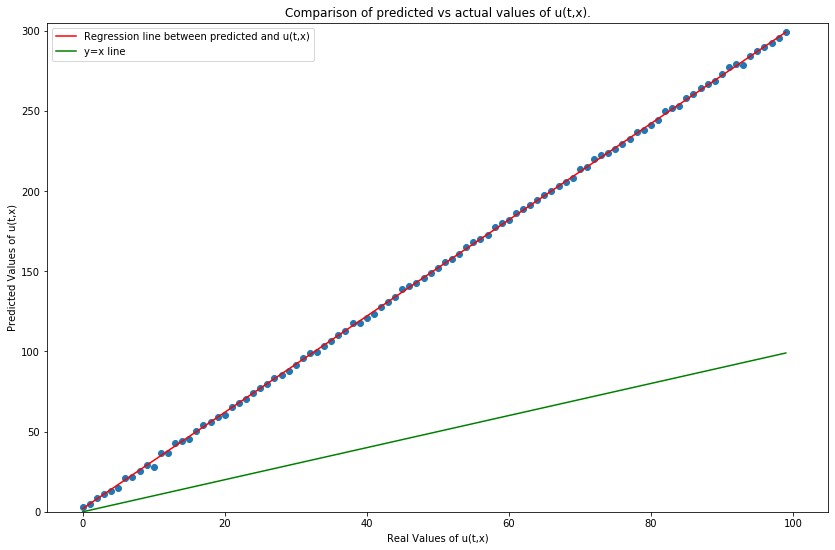

In [20]:
'''fig = plt.figure(figsize=(14, 9))
plt.scatter(real, prediction)
plt.plot(real, b + real * a, 'r', label='Regression line between predicted and u(t,x)')
plt.plot(real, real, 'g', label='y=x line')
plt.title("Comparison of predicted vs actual values of u(t,x).")
plt.xlabel("Real Values of u(t,x)")
plt.ylabel("Predicted Values of u(t,x)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.axis([-5, 105, 0, 305])
plt.show();'''